In [2]:
import xarray as xr
import numpy as np
from datetime import timedelta
from functions import and_kua_sst
import matplotlib.pyplot as plt
%matplotlib inline

import climt
from sympl import TimeDifferencingWrapper, DataArray, NetCDFMonitor

## Create the model

In [2]:
simple_physics = TimeDifferencingWrapper(climt.SimplePhysics())
convection = climt.EmanuelConvection()
radiation = climt.GrayLongwaveRadiation()
dycore = climt.GFSDynamicalCore([simple_physics, radiation, convection], 
                                number_of_damped_levels=2)

In [3]:
grid = climt.get_grid(nx=64, ny=32, nz=10)

## Create initial state

In [4]:
state = climt.get_default_state([dycore], grid_state=grid)

In [5]:
state['surface_temperature'] = DataArray(
    and_kua_sst(state['latitude'].values),
    dims=['lat', 'lon'],
    attrs={'units': 'degK'}
)

In [6]:
state['eastward_wind'].values[:] = np.random.randn(*state['eastward_wind'].shape)

## Step forward

In [ ]:
model_time_step = timedelta(seconds=1800)
for t in range(48*20):
    diag, state = dycore(state, model_time_step)
    state.update(diag)
    state['time'] += model_time_step

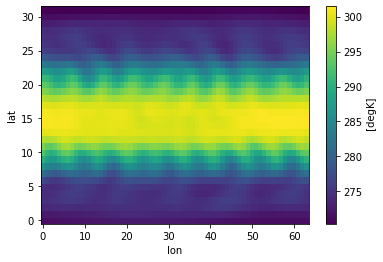

In [5]:
state['air_temperature'].isel(mid_levels=0).plot();

In [4]:
import pickle
with open('./state_and_kua.pkl', 'rb') as f:
    state = pickle.load(f)

## ML parameterization

In [ ]:
class MLConvection(TendencyComponent):
    input_properties = {
        'air_temperature': {
            'dims': ['*', 'mid_levels'],
            'units': 'degK',
        },
        'specific_humidity': {
            'dims': ['*', 'mid_levels'],
            'units': 'kg/kg',
        },
        'eastward_wind': {
            'dims': ['*', 'mid_levels'],
            'units': 'm s^-1',
        },
        'northward_wind': {
            'dims': ['*', 'mid_levels'],
            'units': 'm s^-1',
        },
        'air_pressure': {
            'dims': ['*', 'mid_levels'],
            'units': 'mbar',
        },
    }
    
    diagnostic_properties = {
        'convective_precipitation_rate': {
            'dims': ['*'],
            'units': 'mm day^-1',
        }
    }
    
    tendency_properties = {
        'air_temperature': {'units': 'degK s^-1'},
        'specific_humidity': {'units': 'kg/kg s^-1'},
        'eastward_wind': {'units': 'm s^-2'},
        'northward_wind': {'units': 'm s^-2'},
    }
    
    def __init__(self, model, input_means=None, input_stds=None, 
                 output_means=None, output_stds=None, **kwargs):
        self.model = model
        self.input_means, self.input_stds, self.output_means, self.output_stds = \
            input_means, input_stds, output_means, output_stds
        super().__init__(**kwargs)
        
    def array_call(self, state):
        # Allocate arrays
        tendencies = initialize_numpy_arrays_with_properties(
            self.tendency_properties, state, self.input_properties
        )
        diagnostics = initialize_numpy_arrays_with_properties(
            self.diagnostic_properties, state, self.input_properties
        )
        
        # Concat input dimension
        ncol, nz = state['air_temperature'].shape
        input_arr = []
        for var in input_vars:
            input_arr.append(state[var])
            if var == 'air_pressure': input_arr[-1] *= 100
        input_arr = np.concatenate(input_arr, 1)
        
        # Normalize-predict-unnormalize
        input_arr = normalize(input_arr, self.input_means, self.input_stds)
        preds = self.model.predict(input_arr)
        preds = unnormalize(preds, self.output_means, self.output_stds)
        
        # Split into tendencies
        tendencies['air_temperature'] = preds[:, :nz]
        tendencies['specific_humidity'] = preds[:, nz:nz*2]
        tendencies['eastward_wind'] = preds[:, nz*2:nz*3]
        tendencies['northward_wind'] = preds[:, nz*3:nz*4]
        diagnostics['convective_precipitation_rate'] = preds[:, -1]
        return tendencies, diagnostics